# Quality Assessment
For this part, we use *recording channel amplitude vector* which is a n_channnels×1  positive  vector  of  the  robust  standard  deviations (1.4826 times of the  median  absolute  deviation  from  the  sample median) of the filtered channel signals from channels (Shamlo et al., 2020).

Due to the robust estimators being used, these measures are partially biased towards brain signals rather than  artifacts, and can thus be used to track impacts on those brain signals before and after a given pre-processing method is applied (Robbins et al., 2020).

In particular, we aim at assessing the quality of data before and after Autoreject and ICA in order to make an informed decision about necessity of running ICA in the pipeline for eliminating ocular artefacts in our data.

## Setup

In [2]:
# Import necessary modules
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne_bids
from pathlib import Path
from autoreject import AutoReject
from autoreject import get_rejection_threshold
from pyprep.prep_pipeline import PrepPipeline
from scipy.stats import median_abs_deviation
import copy



# utility function transalted from Vislab's MATLAB code to python
def dispersion_with_mean(matrix):
    """
    calculate dispersion vector [1]
    this function use mean for normalization

    Parameters
    ----------
    matrix : array-like
        amplitude matrix. rows are channels and columns are recordings

    Reference
    ---------
    [1] Bigdely-Shamlo, N., Touryan, J., Ojeda, A., Kothe, C., Mullen, T., & Robbins, K. (2020).
    Automated EEG mega-analysis I: Spectral and amplitude characteristics across studies. NeuroImage, 207, 116361.

    """
    mean_amp = matrix.mean(1)
    matrix_normalized = matrix / mean_amp
    stdFromMad = 1.4826 * median_abs_deviation(matrix_normalized,1)
    dispersion = stdFromMad / np.median(matrix_normalized); 

    return dispersion

def make_continious_data(subject, bids_root='data/Main-study', tasks='all'):
    """
    This function concatenate recordings of one subject in bids format

    """
    session = '01'
    if tasks == 'all':
        tasks = [
            'induction1', 'experience1', 
            'induction2', 'experience2',
            'induction3', 'experience3',
            'induction4', 'experience4',
            'baseline2'
        ]

    # open baseline1
    bids_path = mne_bids.BIDSPath(subject=subject, session=session, task='baseline1', root=bids_root)
    raw = mne_bids.read_raw_bids(bids_path, verbose=False)
    raw = _cut_noisy(raw, 'baseline1', 'hun')

    for task in tasks:
        bids_path = mne_bids.BIDSPath(subject=subject, session=session, task=task, root=bids_root)
        raw_temp = mne_bids.read_raw_bids(bids_path, verbose=False)
        if task[:-1] in ['baseline', 'experience']:
            print(task)
            raw_temp = _cut_noisy(raw_temp, task, 'hun')   
        raw.append(raw_temp)


def make_amplitude_matrix(ampVectors):
    """
    ampVectors : list of np.array
    
    """
    amplitude_matrix = [
        np.append(np.zeros(ampVectors[0].shape), ampVectors[i])
        for i in range(len(ampVectors))
    ]
    amplitude_matrix = np.delete(amplitude_matrix, 0, axis=0)
    return amplitude_matrix

def make_montage(path='data/raw/plb-hyp-live2131111.vhdr'):
    """
    Create a montage from barin vision raw data

    Parameters
    ----------
    path : str
        path to barinvision data header file

    """
    raw = mne.io.read_raw_brainvision(path, verbose=False, misc=['ECG'])
    raw.set_channel_types({'ECG': 'ecg'})
    ch_names = copy.deepcopy(raw.info['ch_names'])  # make a deep copy of the lists of the
    # channel names otherwise ecg channel will be removed in the raw object!!

    ch_names.remove('ECG')
    pos_array = raw._get_channel_positions()
    pos_dict = dict(zip(ch_names, pos_array))
    pos = mne.channels.make_dig_montage(pos_dict)

    return pos
    

Extracting parameters from /Users/yeganeh/Codes/otka-preprocessing/data/Main-study/sub-01/ses-01/eeg/sub-01_ses-01_task-experience1_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 416388  =      0.000 ...   416.388 secs...
Reading events from /Users/yeganeh/Codes/otka-preprocessing/data/Main-study/sub-01/ses-01/eeg/sub-01_ses-01_task-experience1_events.tsv.
Reading channel info from /Users/yeganeh/Codes/otka-preprocessing/data/Main-study/sub-01/ses-01/eeg/sub-01_ses-01_task-experience1_channels.tsv.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth:

/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_52419/2130805320.py:88: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['ECG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(path, verbose=False, misc=['ECG'])
/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_52419/2130805320.py:89: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  raw.set_channel_types({'ECG': 'ecg'})
/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_52419/1351199400.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(pos)


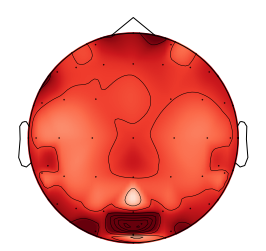

(<matplotlib.image.AxesImage at 0x7f8951b89af0>,
 <matplotlib.contour.QuadContourSet at 0x7f8951b89d90>)

In [3]:
# raw = mne.io.read_raw_brainvision('data/raw/plb-hyp-live2131111.vhdr', misc=['ECG'], preload=True, verbose=False)
# raw.set_channel_types({'ECG':'ecg'})
subject='01'
session = '01'
task = 'experience1'
bids_root = '/Users/yeganeh/Codes/otka-preprocessing/data/Main-study'
bids_path = mne_bids.BIDSPath(subject=subject, session=session, task=task, root=bids_root)
sampling_freq = 1000

raw = mne_bids.read_raw_bids(bids_path, extra_params={'preload':True}, verbose=False) 
raw.crop(100,300)
raw.set_eeg_reference()
raw.filter(1,20)
raw.drop_channels(['ECG', 'EOG1', 'EOG2'])
# Calculate robust std from MAD
ampvector = 1.4826 * median_abs_deviation(raw.get_data(),1)

pos = make_montage()
raw.set_montage(pos)
pos = raw.get_montage()

ch_pos = np.array(list(pos.get_positions()['ch_pos'].values())) 
ch_pos = ch_pos[:,0:2]

mne.viz.plot_topomap(ampvector, ch_pos)